In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os


In [3]:

# --- KONFIGURASI PATH (Sesuaikan dengan Dataset Kaggle Anda) ---
PATH_FOTO_1 = '/kaggle/input/sift-viskom/foto1.jpg' 
PATH_FOTO_2 = '/kaggle/input/sift-viskom/foto2.jpg' 

# Konfigurasi Visualisasi
THICKNESS_GARIS = 3   # Ketebalan garis matching (semakin besar semakin tebal)
RADIUS_TITIK = 10     # Ukuran lingkaran keypoint (semakin besar semakin jelas)
WARNA_GARIS = (0, 255, 0) # Hijau (R, G, B)

In [4]:
def resize_image(img, scale_percent=40):
    """Mengecilkan gambar agar proses lebih cepat."""
    if img is None: return None
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    return cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

def rotate_image(image, angle):
    """Memutar gambar sejauh sudut tertentu (derajat) untuk uji coba SIFT."""
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [5]:
def draw_custom_matches(img1, kp1, img2, kp2, matches, thickness=2):
    """
    Fungsi manual untuk menggambar garis matching agar bisa DIATUR KETEBALANNYA.
    """
    # 1. Buat kanvas kosong gabungan (sebelah-sebelahan)
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    vis = np.zeros((max(h1, h2), w1 + w2, 3), dtype="uint8")
    
    # Tempel gambar
    vis[:h1, :w1] = img1
    vis[:h2, w1:w1+w2] = img2

    # 2. Gambar Garis Tebal
    for m in matches:
        # Ambil koordinat titik (x, y)
        pt1 = (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1]))
        pt2 = (int(kp2[m.trainIdx].pt[0] + w1), int(kp2[m.trainIdx].pt[1])) # geser x gambar kedua
        
        # Gambar Garis
        cv2.line(vis, pt1, pt2, WARNA_GARIS, thickness)
        
        # Gambar Titik Ujung (Lingkaran)
        cv2.circle(vis, pt1, 5, (255, 0, 0), -1) # Titik Merah di img1
        cv2.circle(vis, pt2, 5, (0, 0, 255), -1) # Titik Biru di img2
        
    return vis

def draw_thick_keypoints(img, keypoints, radius=5, color=(255, 255, 0)):
    """Menggambar keypoint dengan lingkaran tebal."""
    vis = img.copy()
    for kp in keypoints:
        center = (int(kp.pt[0]), int(kp.pt[1]))
        # Gambar lingkaran luar
        cv2.circle(vis, center, radius, color, 2)
        # Gambar titik tengah
        cv2.circle(vis, center, 2, (0, 0, 255), -1)
    return vis

Ukuran Img1: (4608, 3456, 3), Ukuran Img2: (4608, 3456, 3)


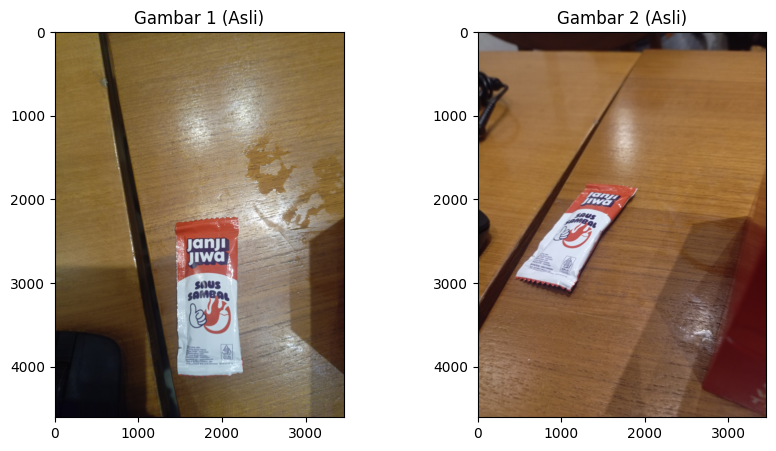

In [6]:
# 1. Load Gambar
img1_ori = cv2.imread(PATH_FOTO_1)
img2_ori = cv2.imread(PATH_FOTO_2)

if img1_ori is None or img2_ori is None:
    print("❌ ERROR: Gambar tidak ditemukan! Cek path di Cell 1.")
else:
    # 2. Resize (Opsional: Kecilkan 50% biar tidak terlalu berat jika gambar 4K)
    img1 = resize_image(img1_ori, scale_percent=50)
    img2 = resize_image(img2_ori, scale_percent=50)
    
    print(f"Ukuran Img1: {img1.shape}, Ukuran Img2: {img2.shape}")

    # Tampilkan Gambar Asli
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1); plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)); plt.title("Gambar 1 (Asli)")
    plt.subplot(1, 2, 2); plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)); plt.title("Gambar 2 (Asli)")
    plt.show()

🔄 Memutar Gambar 2 sejauh 45 derajat...


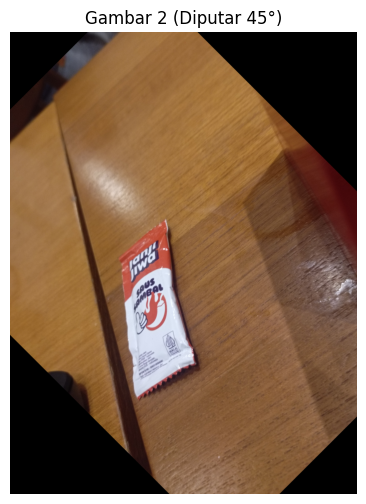

In [7]:
# --- SETTING ROTASI ---
SUDUT_ROTASI = 45 # Coba ganti: 45, 90, 180

print(f"🔄 Memutar Gambar 2 sejauh {SUDUT_ROTASI} derajat...")
img2 = rotate_image(img2, SUDUT_ROTASI)

# Tampilkan hasil rotasi
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title(f"Gambar 2 (Diputar {SUDUT_ROTASI}°)")
plt.axis('off')
plt.show()

🚀 Menjalankan SIFT Detect...
✅ Selesai! Img1: 14537 keypoints, Img2: 1837 keypoints


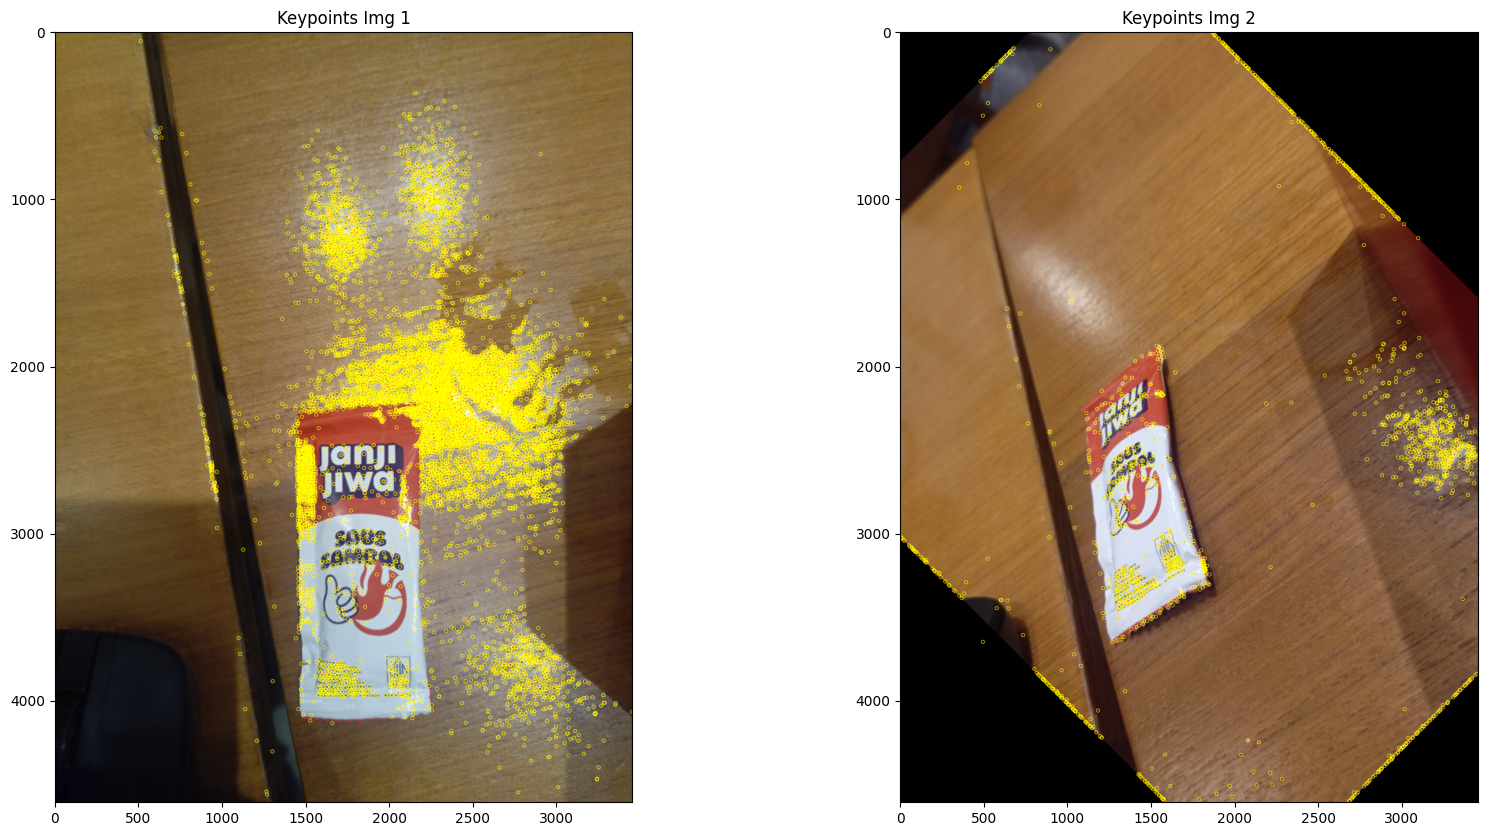

In [8]:
# 1. Konversi ke Grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# 2. Inisialisasi SIFT
print("🚀 Menjalankan SIFT Detect...")
sift = cv2.SIFT_create()

# 3. Detect & Compute
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

print(f"✅ Selesai! Img1: {len(kp1)} keypoints, Img2: {len(kp2)} keypoints")

# 4. VISUALISASI KEYPOINTS TEBAL
vis_kp1 = draw_thick_keypoints(img1, kp1, radius=RADIUS_TITIK, color=(0, 255, 255))
vis_kp2 = draw_thick_keypoints(img2, kp2, radius=RADIUS_TITIK, color=(0, 255, 255))

# Tampilkan Side-by-Side
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1); plt.imshow(cv2.cvtColor(vis_kp1, cv2.COLOR_BGR2RGB)); plt.title("Keypoints Img 1")
plt.subplot(1, 2, 2); plt.imshow(cv2.cvtColor(vis_kp2, cv2.COLOR_BGR2RGB)); plt.title("Keypoints Img 2")
plt.show()

🔗 Mencocokkan Fitur...
✅ Ditemukan 89 titik cocok (Good Matches).


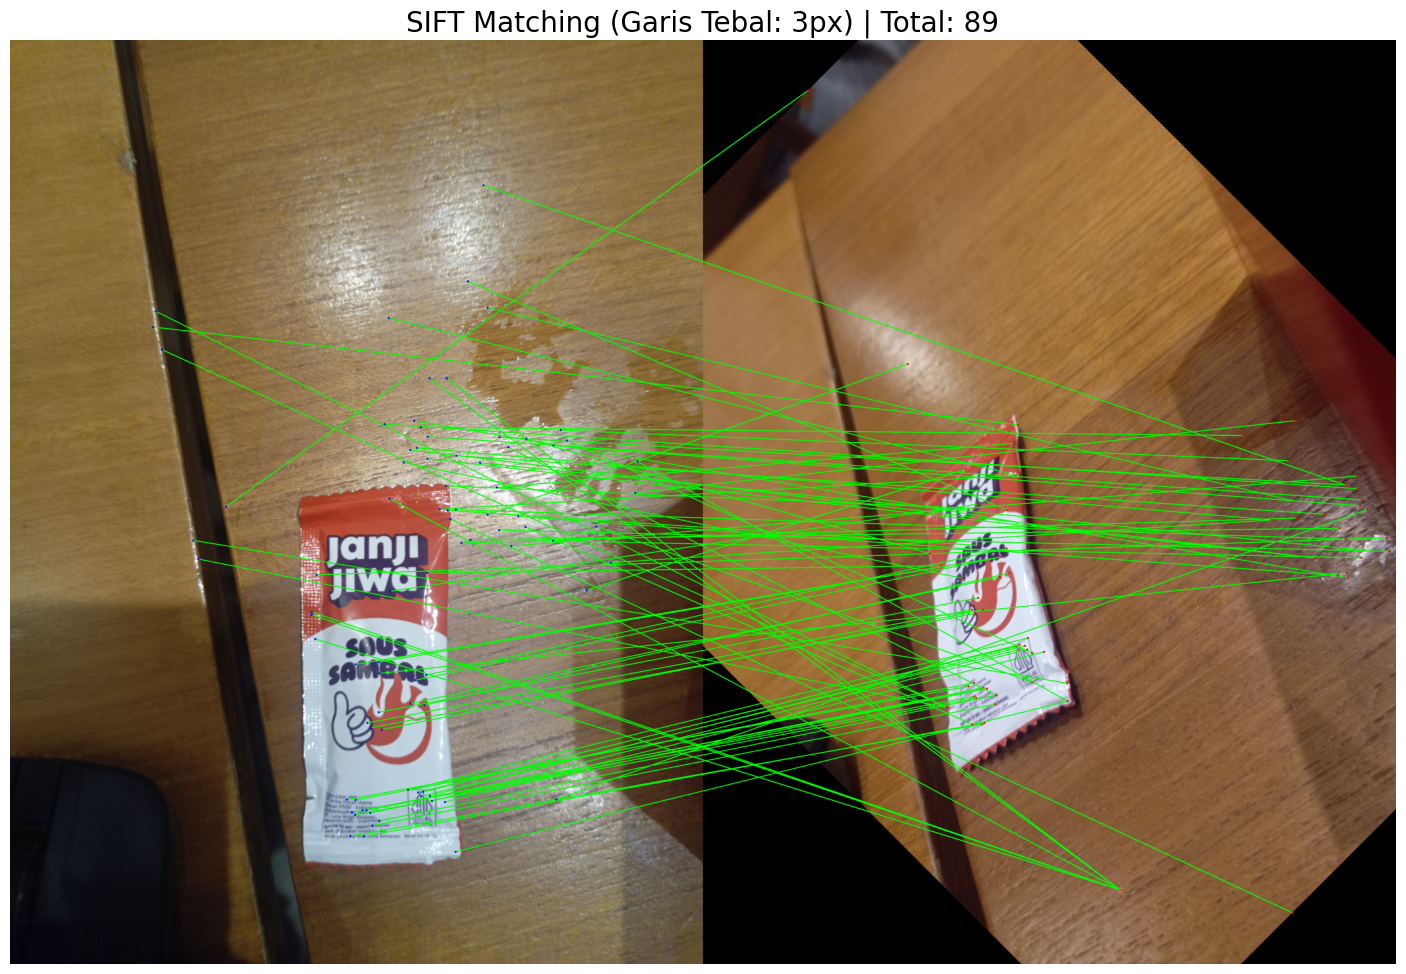

In [10]:
# 1. Matching (KNN)
print("🔗 Mencocokkan Fitur...")
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# 2. Filter Good Matches (Lowe's Ratio)
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m) # Perhatikan di sini append(m) bukan [m] agar support draw_custom

print(f"✅ Ditemukan {len(good_matches)} titik cocok (Good Matches).")

# 3. VISUALISASI GARIS TEBAL (CUSTOM)
# Kita pakai fungsi buatan sendiri di Cell 3
img_result_thick = draw_custom_matches(img1, kp1, img2, kp2, good_matches, thickness=THICKNESS_GARIS)

# Tampilkan Besar
plt.figure(figsize=(25, 12)) # Ukuran jumbo
plt.imshow(cv2.cvtColor(img_result_thick, cv2.COLOR_BGR2RGB))
plt.title(f"SIFT Matching (Garis Tebal: {THICKNESS_GARIS}px) | Total: {len(good_matches)}", fontsize=20)
plt.axis('off')
plt.show()